In [1]:
from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import math

from keras.utils. generic_utils import Progbar

### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

### generator model define
def generator_model():
    inputs = Input((10,))
    fc1 = Dense(input_dim=10, units=128*7*7)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)
    fc2 = Reshape((7, 7, 128), input_shape=(128*7*7,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3, 3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(1, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

### discriminator model define
def discriminator_model():
    inputs = Input((28, 28, 1))
    conv1 = Conv2D(64, (5, 5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (5, 5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

### d_on_g model for training generator
def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(10,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    # gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def load_model():
    d = discriminator_model()
    g = generator_model()
    d_optim = RMSprop()
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    d.load_weights('weights/discriminator.h5')
    g.load_weights('weights/generator.h5')
    return g, d

### train generator and discriminator
def train(BATCH_SIZE, X_train):
    
    ### model define
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = RMSprop(lr=0.0004)
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='mse', optimizer=g_optim)
    d_on_g.compile(loss='mse', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='mse', optimizer=d_optim)
    

    for epoch in range(10):
        print ("Epoch is", epoch)
        n_iter = int(X_train.shape[0]/BATCH_SIZE)
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # create random noise -> U(0,1) 10 latent vectors
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 10))

            # load real data & generate fake data
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            
            # visualize training results
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                cv2.imwrite('./result/'+str(epoch)+"_"+str(index)+".png", image)

            # attach label for training discriminator
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            
            # training discriminator
            d_loss = d.train_on_batch(X, y)

            # training generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True

            progress_bar.update(index, values=[('g',g_loss), ('d',d_loss)])
        print ('')

        # save weights for each epoch
        g.save_weights('weights/generator.h5', True)
        d.save_weights('weights/discriminator.h5', True)
    return d, g

### generate images
def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('weights/generator.h5')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 10))
    generated_images = g.predict(noise)
    return generated_images

### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = discriminator_model()
        d.load_weights('weights/discriminator.h5') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

### anomaly detection model define
def anomaly_detector(g=None, d=None):
    if g is None:
        g = generator_model()
        g.load_weights('weights/generator.h5')
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(10,))
    gInput = Dense((10), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model

### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.uniform(0, 1, size=(1, 10))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

Using TensorFlow backend.


In [0]:
import os
os.mkdir("weights")

In [0]:
from __future__ import print_function
import matplotlib


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import argparse

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_test_original = X_test.copy()

X_train = X_train[y_train==1]
X_test = X_test[y_test==1]
print ('train shape:', X_train.shape)
print ('test shape:', X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
train shape: (6742, 28, 28, 1)
test shape: (6742, 28, 28, 1)


In [8]:
Model_d, Model_g = train(64, X_train)

Epoch is 0
103/105 [============================>.] - ETA: 0s - g: 0.3060 - d: 0.1799
Epoch is 1
104/105 [============================>.] - ETA: 0s - g: 0.1077 - d: 0.1447
Epoch is 2
104/105 [============================>.] - ETA: 0s - g: 0.2234 - d: 0.1841
Epoch is 3
102/105 [============================>.] - ETA: 0s - g: 0.2692 - d: 0.2177
Epoch is 4
103/105 [============================>.] - ETA: 0s - g: 0.2857 - d: 0.2230
Epoch is 5
104/105 [============================>.] - ETA: 0s - g: 0.2836 - d: 0.2277
Epoch is 6
103/105 [============================>.] - ETA: 0s - g: 0.2707 - d: 0.2357
Epoch is 7
102/105 [============================>.] - ETA: 0s - g: 0.2710 - d: 0.2382
Epoch is 8
103/105 [============================>.] - ETA: 0s - g: 0.2673 - d: 0.2354
Epoch is 9
103/105 [============================>.] - ETA: 0s - g: 0.2683 - d: 0.2341


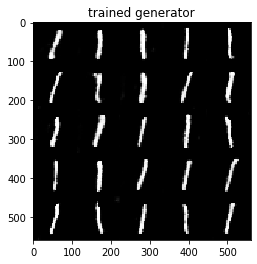

In [9]:

generated_img = generate(25)
img = combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)



plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()



In [0]:
def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img =compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(28,28,1) - similar_img.reshape(28,28,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
7 label, 16 : done 126.04 6963.74ms
anomaly score :  126.043701171875


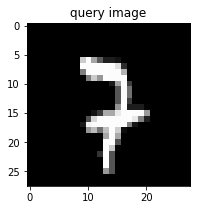

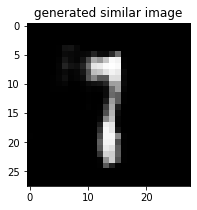

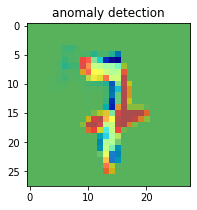

In [15]:
img_idx = 16
label_idx = 7
test_img = X_test_original[y_test==label_idx][img_idx]

start = cv2.getTickCount()
score, qurey, pred, diff = anomaly_detection(test_img)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
print ('%d label, %d : done'%(label_idx, img_idx), '%.2f'%score, '%.2fms'%time)

plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(qurey.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

random noise image
100/100 [==============================] - 0s 135us/step


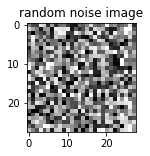

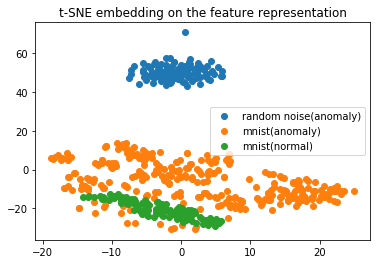

In [16]:
from sklearn.manifold import TSNE

random_image = np.random.uniform(0, 1, (100, 28, 28, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)

# intermidieate output of discriminator
model = feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test_original[y_test != 1][:300], verbose=1)
feature_map_of_minist_1 = model.predict(X_test[:100], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist, feature_map_of_minist_1))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400,0], X_embedded[100:400,1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:,0], X_embedded[400:,1], label='mnist(normal)')
plt.legend()
plt.show()